In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

In [3]:
def logreg_predict_proba_metrics(X, y, c, n_simulations=10, test=0.3, sync=False, seed=[], choice=False):

    # select seed for each simulation
    if len(seed)!=n_simulations:
        seed = np.random.randint(100000, size=n_simulations)

    # initialize arrays for LR results
    lr_predict = np.zeros((int(np.round(test*len(X))),n_simulations))
    lr_proba = np.zeros((int(np.round(test*len(X))), 2))
    lr_score = np.zeros(n_simulations)
    metrics = np.zeros((4,2))
    coefs = np.zeros((X.shape[1]))
    y_test_full = np.zeros((int(np.round(test*len(X))),n_simulations))

    for i in range(n_simulations):
        X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, test_size=test, random_state=seed[i])

        lr = LogisticRegression()
        lr.fit(X_train, y_train)

        lr_proba = np.dstack((lr_proba, lr.predict_proba(X_test)))
        lr_predict[:,i] = lr.predict(X_test)
        lr_score[i] = lr.score(X_test, y_test)
        metrics_temp = sklearn.metrics.precision_recall_fscore_support(y_test, lr_predict[:,i])
        metrics = np.dstack((metrics, np.array(metrics_temp)))
        
        if choice==True:
            metrics_switch = np.zeros((4,2))
            switch_predict = np.zeros((int(np.round(test*len(X))),n_simulations))
            
            prev_choice = c_test['1_Port']
            switch_true = np.abs(y_test-prev_choice)
            switch_predict[:,i] = np.abs(lr_predict[:,i]-prev_choice)
            metrics_switch_temp = sklearn.metrics.precision_recall_fscore_support(switch_true, switch_predict[:,i])
            metrics_switch = np.dstack((metrics_switch, np.array(metrics_switch_temp)))

        coefs = np.dstack((coefs, lr.coef_))
        y_test_full[:,i] = y_test
    # clean up from initializing 3d stacks with zeros
    metrics = metrics[:,:,1:n_simulations+1]
    lr_proba = lr_proba[:,:,1:n_simulations+1]
    coefs = coefs[:,:,1:n_simulations+1]
    
    if sync==True: 
        return metrics, lr_predict, lr_proba, lr_score, seed, coefs, y_test_full
    elif choice==True:
        metrics_switch = metrics_switch[:,:,1:n_simulations+1]

        return metrics_switch, lr_predict, lr_proba, lr_score, coefs, y_test_full
    else:
        return metrics, lr_predict, lr_proba, lr_score, coefs, y_test_full

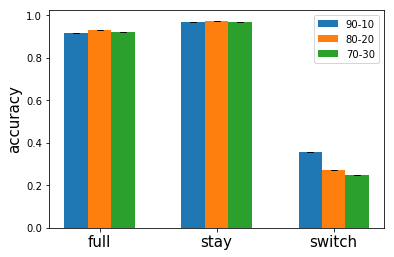

In [5]:
n_sims=100
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)

seed1 = np.random.randint(100000,size=n_sims)

X_9010, y_9010, c_9010 = bm.feature_history(data[data['Condition']=='90-10'], 
                                            X_dataframe='choice', y_dataframe='choice')
metrics9010, lr_predict9010, lr_proba9010, lr_score9010, coefs9010, y_test_9010 = logreg_predict_proba_metrics(X_9010, 
                                            y_9010, c_9010, n_simulations=n_sims, seed=seed1, choice=True)

X_8020, y_8020, c_8020 = bm.feature_history(data[data['Condition']=='80-20'], 
                                            X_dataframe='choice', y_dataframe='choice')
metrics8020, lr_predict8020, lr_proba8020, lr_score8020, coefs8020, y_test_8020 = logreg_predict_proba_metrics(X_8020, 
                                            y_8020, c_8020, n_simulations=n_sims, seed=seed1, choice=True)

X_7030, y_7030, c_7030 = bm.feature_history(data[data['Condition']=='70-30'], 
                                            X_dataframe='choice', y_dataframe='choice')
metrics7030, lr_predict7030, lr_proba7030, lr_score7030, coefs7030, y_test_7030 = logreg_predict_proba_metrics(X_7030, 
                                            y_7030, c_7030, n_simulations=n_sims, seed=seed1, choice=True)

'''PLOT'''

height_9010 = [np.mean(lr_score9010), np.mean(metrics9010[1,0,:]), np.mean(metrics9010[1,1,:])]
ystd1 = [np.std(lr_score9010), np.std(metrics9010[1,0,:]), np.std(metrics9010[1,1,:])]
yerr1 = [ystd1[i] / np.sqrt(n_sims) for i in range(len(ystd1))]

height_8020 = [np.mean(lr_score8020), np.mean(metrics8020[1,0,:]), np.mean(metrics8020[1,1,:])]
ystd2 = [np.std(lr_score8020), np.std(metrics8020[1,0,:]), np.std(metrics8020[1,1,:])]
yerr2 = [ystd2[i] / np.sqrt(n_sims) for i in range(len(ystd2))]

height_7030 = [np.mean(lr_score7030), np.mean(metrics7030[1,0,:]), np.mean(metrics7030[1,1,:])]
ystd3 = [np.std(lr_score7030), np.std(metrics7030[1,0,:]), np.std(metrics7030[1,1,:])]
yerr3 = [ystd3[i] / np.sqrt(n_sims) for i in range(len(ystd3))]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_9010))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_9010, width=barWidth, label='90-10', yerr=yerr1, capsize=3)
plt.bar(r2, height_8020, width=barWidth, label='80-20', yerr=yerr2, capsize=3)
plt.bar(r3, height_7030, width=barWidth, label='70-30', yerr=yerr3, capsize=3)

plt.xticks(r2, conditions, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test_9010[:,0], lr_proba9010[:,1,0])
plt.plot(fpr, tpr, label="90-10")
fpr, tpr, _ = roc_curve(y_test_8020[:,0], lr_proba8020[:,1,0])
plt.plot(fpr, tpr, label="80-20")
fpr, tpr, _ = roc_curve(y_test_7030[:,0], lr_proba7030[:,1,0])
plt.plot(fpr, tpr, label="70-30")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate', size=15)
plt.ylabel('true positive rate', size=15)
plt.title('Logistic regression ROC curve', size=15)
plt.legend(prop={'size':15})
plt.show()

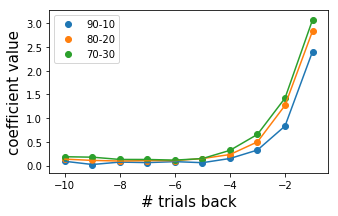

In [9]:
plt.figure(figsize=(5,3))
#plt.plot(np.arange(-coefs9010.shape[1],0),coefs9010.mean(axis=2)[0,:])
plt.scatter(np.arange(-coefs9010.shape[1],0),coefs9010.mean(axis=2)[0,:], label='90-10')
yerr1 = coefs9010.std(axis=2)/np.sqrt(n_sims)
plt.errorbar(np.arange(-coefs9010.shape[1],0),coefs9010.mean(axis=2)[0,:], yerr=yerr1[0,:])

#plt.plot(np.arange(-coefs8020.shape[1],0),coefs8020.mean(axis=2)[0,:])
plt.scatter(np.arange(-coefs8020.shape[1],0),coefs8020.mean(axis=2)[0,:], label='80-20')
yerr1 = coefs8020.std(axis=2)/np.sqrt(n_sims)
plt.errorbar(np.arange(-coefs8020.shape[1],0),coefs8020.mean(axis=2)[0,:], yerr=yerr1[0,:])

#plt.plot(np.arange(-coefs7030.shape[1],0),coefs7030.mean(axis=2)[0,:])
plt.scatter(np.arange(-coefs7030.shape[1],0),coefs7030.mean(axis=2)[0,:], label='70-30')
yerr1 = coefs7030.std(axis=2)/np.sqrt(n_sims)
plt.errorbar(np.arange(-coefs7030.shape[1],0),coefs7030.mean(axis=2)[0,:], yerr=yerr1[0,:])

plt.ylabel('coefficient value', size=15)
plt.xlabel('# trials back', size=15)
plt.legend()


plt.show()

## Shuffled data for null

In [ ]:
prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, yerr=yerr1, capsize=3, label='90-10')
plt.bar(r2, height_b, width=barWidth, yerr=yerr2, capsize=3, label='80-20')
plt.bar(r3, height_c, width=barWidth, yerr=yerr3, capsize=3, label='70-30')
plt.bar(r1[2], height_a_shuffled, width=barWidth, label='shuffled', color='gray', alpha=0.8, edgeColor='gray')
plt.bar(r2[2], height_b_shuffled, width=barWidth, color='gray', alpha=0.8)
plt.bar(r3[2], height_c_shuffled, width=barWidth, color='gray', alpha=0.8)


plt.xticks(r2, prob_labels, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()



In [ ]:
X, y, c = bm.feature_history(data, X_dataframe='choice', y_dataframe='choice')
metrics, lr_predict, lr_proba, lr_score, coefs = logreg_predict_proba_metrics(X, 
                                                                    y, c, n_simulations=100, seed=seed1, choice=True)

height = [np.mean(lr_score), np.mean(metrics[1,0,:]), np.mean(metrics[1,1,:])]
ystd1 = [np.std(lr_score), np.std(metrics[1,0,:]), np.std(metrics[1,1,:])]
yerr1 = [ystd1[i] / np.sqrt(n_sims) for i in range(len(ystd1))]

barWidth = 0.4
# The x position of bars
r1 = np.arange(len(height))

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height, width=barWidth, yerr=yerr1, capsize=3)

plt.xticks(range(len(height)), conditions, size=20)
plt.ylabel('accuracy', size=20)
plt.legend()
plt.show()

In [ ]:
metrics_switch[3,1]/metrics_switch[3,:].sum() # prevalence of switches